Let's get monthly average temperatures in Seoul (서울), South Korea.

Data Source
- **KMA:** Korea Meteorological Administration (대한민국 기상청)

# Load Library

In [1]:
from multiprocessing.dummy import Pool

from scipy import interpolate

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

# Set plotting style

In [2]:
sns.set_style('whitegrid')
sns.set_context('talk')

# xml info

| 항목명(영문 약자) | 항목명(한글)   |
|-----------------|--------------|
| stnid           | 지역번호      |
| stnko           | 지역이름(한글) |
| avgtamax        | 기온-최고-평균 |
| avgtamin        | 기온-최저-평균 |
| taavg           | 기온-평균     |

# Data Loader

## for single

In [3]:
def average_temperature_monthly(year, month, city='서울', echo=False):
    """Average temperature (monthly) from KMA
    
    KMA: Korea Meteorological Administration
    
    Args:
        year  (int):
        month (int):
        city  (str): '서울' by default
        
    Returns:
        average_temperature (float):
    """
    import time
    import urllib3
    
    import numpy as np
    import requests
    
    from lxml import etree

    
    urllib3.disable_warnings()
    
    if echo is True:
        print(year, month, city)
    
    BASE_URL = 'https://data.kma.go.kr'
    
    url = '{BASE_URL}/OPEN_API/SYNM/{year}/{month:02d}/XML/month1.xml'.format(
        BASE_URL = BASE_URL,
        year  = year,
        month = month
    )
    
    r = requests.get(url, verify=False)
    
    if '공사중' in r.content.decode('utf-8'):
        average_temperature = np.nan
    else:
        root = etree.fromstring(r.content)

        city_xml = [
            child 
            for child in root 
            if child.xpath('stnko')[0].text == city
        ]

        average_temperature = float(city_xml[0].xpath('taavg')[0].text)

    return average_temperature

## for multi

In [4]:
def average_temperature_monthly_multi(year_month, city='서울', echo=False):
    """Average temperature (monthly) from KMA
    
    KMA: Korea Meteorological Administration
    
    Args:
        year_month (tuple): (year, month)
        city (str): '서울' by default
        
    Returns:
        average_temperature (float):
    """
    import time
    import urllib3
    
    from urllib.parse import urljoin
    
    import numpy as np
    import requests
    
    from lxml import etree

    
    urllib3.disable_warnings()
   
    year, month = year_month

    if echo is True:
        print(year, month, city)
    
    BASE_URL = 'https://data.kma.go.kr/OPEN_API/SYNM/'
    
    sub_url = '{year}/{month:02d}/XML/month1.xml'.format(
        year  = year,
        month = month
    )
    
    url = urljoin(BASE_URL, sub_url)
    
    r = requests.get(url, verify=False)
    
    if '공사중' in r.content.decode('utf-8'):
        average_temperature = np.nan
    else:
        root = etree.fromstring(r.content)

        city_xml = [
            child 
            for child in root 
            if child.xpath('stnko')[0].text == city
        ]

        average_temperature = float(city_xml[0].xpath('taavg')[0].text)

    return average_temperature

# Make year-month pairs

In [5]:
def _year_month_pairs(year, number_of_months):
    year_month_pairs = zip(
        [year] * number_of_months,
        range(1, number_of_months + 1),
    )

    return year_month_pairs

Today is 2018-11-12. September & October aren't ready yet.

In [6]:
year_month_pairs_2017 = _year_month_pairs(2017, 12)
year_month_pairs_2018 = _year_month_pairs(2018, 12)
year_month_pairs_2019 = _year_month_pairs(2019,  4)


year_month_pairs = [
    *year_month_pairs_2017, 
    *year_month_pairs_2018,
    *year_month_pairs_2019
]

# Load monthly temperature data

## single

In [7]:
average_temperature_list = [ 
    average_temperature_monthly(year, month) 
    for year, month in tqdm_notebook(year_month_pairs) 
]

## multi

In [8]:
with Pool(processes=4) as pool:
    average_temperature_list = pool.map(
        average_temperature_monthly_multi, 
        year_month_pairs
    )

# Make temperature value series

In [9]:
average_temperature_series = pd.Series(
    average_temperature_list, 
    index = pd.date_range(
        '20170101', 
        periods=len(average_temperature_list), 
        freq='MS'
    )
)

# Load my electricity usage data

In [10]:
df = pd.read_csv('http://danielykim.me/data/my-electricity-usage.csv')

df['Month'] = pd.to_datetime(df['Month'])

df = df.set_index('Month')

# Join them

In [11]:
df['AverageTemperature'] = average_temperature_series

# Drop missing values

In [12]:
df = df.dropna()

# Check rows

In [21]:
df.head()

,Usage,SameAreaAverageUsage,AverageTemperature
Month,,,
2017-01-01,81,131.0,-1.8
2017-02-01,69,118.0,-0.2
2017-03-01,64,106.0,6.3
2017-04-01,62,111.0,13.9
2017-05-01,58,114.0,19.5


In [13]:
df.tail()

,Usage,SameAreaAverageUsage,AverageTemperature
Month,,,
2018-10-01,76,144.0,13.1
2018-11-01,83,114.0,7.8
2018-12-01,64,124.0,-0.6
2019-01-01,74,134.0,-0.9
2019-02-01,63,124.0,1.0


# Correlation between columns

In [14]:
df.corr()

,Usage,SameAreaAverageUsage,AverageTemperature
Usage,1.000000,0.950583,0.600636
SameAreaAverageUsage,0.950583,1.000000,0.513035
AverageTemperature,0.600636,0.513035,1.000000


NOTE
- In summer, $W \sim T$
- In winter, $W \sim \frac{1}{T}$

where
- $T=\text{temperature}$
- $W=\text{electricity usage}$

# Preprocessing

## Datetime interpolation helper

In [15]:
def toTimestamp(d):
    import calendar
    
    return calendar.timegm(d.timetuple())

## Datetime axis interpolation

In [22]:
usage_interpolator = interpolate.Rbf(
    [toTimestamp(i) for i in df.index], 
    df.Usage
)

same_area_usage_interpolator = interpolate.Rbf(
    [toTimestamp(i) for i in df.index], 
    df.SameAreaAverageUsage
)

temperature_interpolator = interpolate.Rbf(
    [toTimestamp(i) for i in df.index], 
    df.AverageTemperature
)

## Prepare data for plotting

In [24]:
dates = pd.date_range('20170101', '20190201')

timestamps = [ toTimestamp(i) for i in dates]

In [25]:
usage_values = usage_interpolator(timestamps)

In [26]:
area_usage_values = np.array(same_area_usage_interpolator(timestamps))

area_usage_deviation = area_usage_values * 0.66

In [27]:
temperature_values = np.array(temperature_interpolator(timestamps))

# Plotting

## Draw figure

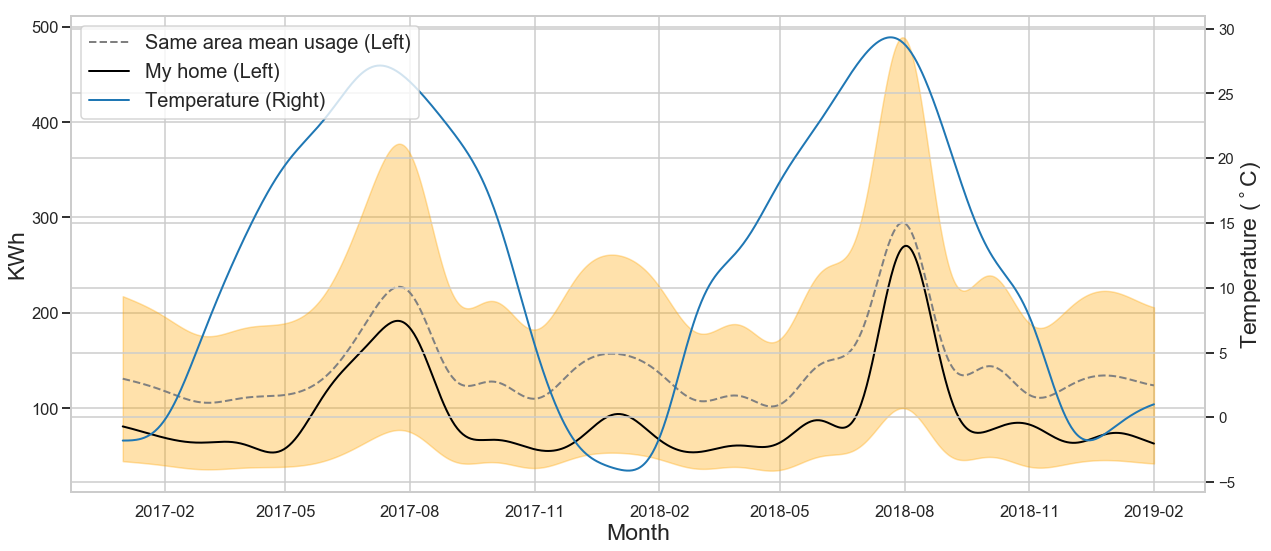

In [37]:
# https://matplotlib.org/gallery/api/two_scales.html
# https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
fig, ax1 = plt.subplots(figsize=(18,8))


# Labels
ax1.set_xlabel('Month', fontsize=23)
ax1.set_ylabel('KWh', fontsize=23)

# Lines
ax1_same_area = ax1.plot(
    dates, area_usage_values, 
    label='Same area mean usage (Left)', 
    linewidth=2, linestyle='--', color='gray'
)
ax1_my_home = ax1.plot(dates, usage_values, label='My home (Left)', linewidth=2, color='black')

# Filled area
ax1.fill_between(
    dates, 
    area_usage_values + area_usage_deviation, 
    area_usage_values - area_usage_deviation, 
    alpha=0.33,
    color='orange'
)


ax2 = ax1.twinx()

ax2.set_ylabel(r"Temperature ($^\circ$C)", fontsize=23)

ax2_temperature = ax2.plot(
    dates, temperature_values, 
    label='Temperature (Right)', linewidth=2
)

plots = ax1_same_area + ax1_my_home + ax2_temperature
legend_labels = [p.get_label() for p in plots]

plt.legend(plots, legend_labels, loc='upper left', fontsize=20)

plt.tick_params(labelsize=15)

# Adjust
plt.tight_layout()

## Autocorrelation Plot

In [19]:
from pandas.plotting import autocorrelation_plot

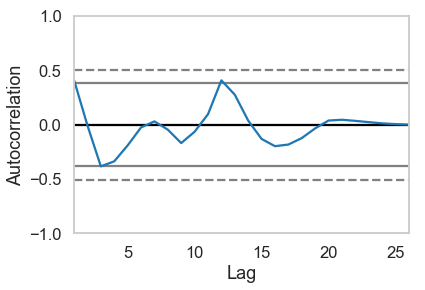

In [20]:
autocorrelation_plot(df.SameAreaAverageUsage.values)